In [1]:
import torch
from torch import nn,optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

In [2]:
use_cuda = torch.cuda.is_available()
#use_cuda = False

In [3]:
def plot_decision_boundarie(ax, xmin, xmax,ymin,ymax, step, model):    
    #generate random points
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step), np.arange(ymin, ymax, step))
    random_points,predictions = np.c_[xx.ravel(), yy.ravel()], []
    
    #call the model to predict each point
    for p in random_points:
        x = torch.tensor(p).float()
        x = x.cpu()
        predicted = model(x)
        predicted = predicted.cpu().data.numpy()[0] if use_cuda else predicted.data.numpy()[0]
        predictions.append(round(predicted))
    predictions = np.array(predictions).reshape(xx.shape)
    
    #plot decision boundary
    ax.contourf(xx, yy, predictions,cmap=plt.cm.Paired, alpha = 0.5)

def train(model,X,Y, num_epocs,learning_rate):
    model = model.float()
    criterion = nn.L1Loss()
    
    #if use_cuda, transfer model to GPU
    if use_cuda:
        print("Transfering models to GPU(s)")
        model = torch.nn.DataParallel(model).cuda() 
        criterion = criterion.cuda()


    #define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    step = 1
    steps, error = [],[]
    for i in range(num_epocs):
        #for each epoch, use the 4 data points to train
        for d in zip(X, Y):
            #if use_cuda transfer variable to GPU
            x = d[0].cuda() if use_cuda else d[0]

            #if use_cuda transfer variable to GPU
            y = d[1].cuda() if use_cuda else d[1]

            #feed forward
            y_pred = model(x)

            #reset the gradients
            optimizer.zero_grad()

            #calculate the error
            loss = criterion(y_pred, y)

            #computes gradients and propagates error back
            loss.backward()

            #update the weights using the gradients
            optimizer.step()

            step += 1
            
        if i % 2000 == 0:
            l = loss.cpu().data.item() if use_cuda else loss.data.item()
            print('Epoch: {0}, Loss: {1}'.format(i, l))
        if i % 500 == 0:
            steps.append(step)
            error.append(loss.data.item())
    return steps, error

Generate the data

In [4]:
X = torch.Tensor([[0,0],[0,1], [1,0], [1,1]])
Y = torch.Tensor([0,1,1,0]).view(-1,1)
X,Y

(tensor([[0., 0.],
         [0., 1.],
         [1., 0.],
         [1., 1.]]),
 tensor([[0.],
         [1.],
         [1.],
         [0.]]))

Plot the data

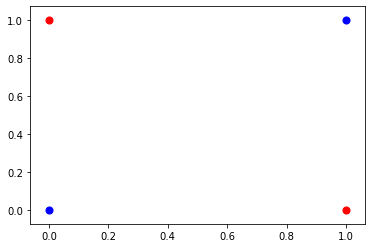

In [5]:
plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1],c='blue', s=50)
plt.scatter(X.numpy()[[1,2], 0], X.numpy()[[1, 2], 1], c='red', s=50)

The MLP has two fully connected layers and an activation function between the hidden and the output layer. (image from http://alexlenail.me/NN-SVG/LeNet.html)

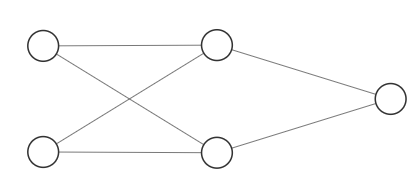

This network has 2 inputs, 2 nodes in the hidden layer and will be trained with the following training settings:

* 20001 epochs;
* Each epoch will use the 4 training examples to train the network;
* learning rate of 0.01;
* Stochastic gradient descent as optimizer;
* L1 Loss as criterion

L1 loss function is given by: 

\begin{align}
l1 = |y1-y2|
\end{align}

where y1 is the predicted value, and y2 is the target

Different networks will be trained with different activation functions. ReLU, hyperbolic tangent and sigmoid will be tested.

Lets plot the activation functions.

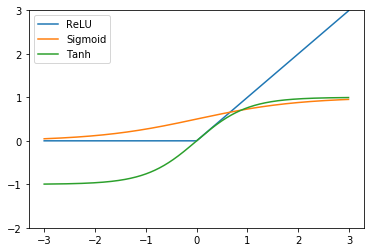

In [6]:
activation_functions = [nn.ReLU,nn.Sigmoid,nn.Tanh]
for act in activation_functions:
    init = act()
    X2 = np.arange(-3, 3, 0.01)
    y2 = [init(torch.tensor(x)) for x in X2]
    plt.plot(X2,y2,label = act.__name__)
    plt.ylim(-2,3)
plt.legend()

Train the 3 neural networks

In [7]:
df_results = pd.DataFrame()

for i in range(len(activation_functions)):
    print('------')
    activation_function = activation_functions[i]
    print('Training model with {} activation function'.format(activation_function.__name__))
    
    hidden_size = 2
    model = nn.Sequential(
              nn.Linear(2,hidden_size),
              activation_function(),
              nn.Linear(hidden_size,1),
        )
    
    epocs = 20000
    learning_rate = 0.01
    steps, errors = train(model, X, Y, epocs, learning_rate)
    df_results = df_results.append({'activation':activation_function.__name__,'errors':errors,'steps':steps,'model': model},ignore_index = True)

------
Training model with ReLU activation function
Transfering models to GPU(s)
Epoch: 0, Loss: 0.8057308197021484
Epoch: 2000, Loss: 0.36586523056030273
Epoch: 4000, Loss: 0.0012121312320232391
Epoch: 6000, Loss: 0.005117930471897125
Epoch: 8000, Loss: 0.005117930471897125
Epoch: 10000, Loss: 0.005117930471897125
Epoch: 12000, Loss: 0.005117930471897125
Epoch: 14000, Loss: 0.005117930471897125
Epoch: 16000, Loss: 0.005117930471897125
Epoch: 18000, Loss: 0.005117930471897125
------
Training model with Sigmoid activation function
Transfering models to GPU(s)
Epoch: 0, Loss: 0.6991279721260071
Epoch: 2000, Loss: 0.048421710729599
Epoch: 4000, Loss: 0.06943365931510925
Epoch: 6000, Loss: 0.0896536260843277
Epoch: 8000, Loss: 0.10892975330352783
Epoch: 10000, Loss: 0.12662263214588165
Epoch: 12000, Loss: 0.14139944314956665
Epoch: 14000, Loss: 0.15076935291290283
Epoch: 16000, Loss: 0.15053953230381012
Epoch: 18000, Loss: 0.16928346455097198
------
Training model with Tanh activation func

Evaluate the three models

In [8]:
for i2, r in df_results.iterrows():
    model = torch.nn.DataParallel(r['model']).cuda() if use_cuda else r['model']
    print('-----')
    print("Predictions of model trained with {} activation function".format(r['activation']))

    for i, target in zip(X, Y):
        predicted = model(i)

        i = i.cpu().data.numpy() if use_cuda else i.data.numpy()

        target = target.cpu().data.numpy()[0] if use_cuda else target.data.numpy()[0]

        predicted = predicted.cpu().data.numpy()[0] if use_cuda else predicted.data.numpy()[0]
        predicted = round(float(predicted), 4)

        error = round(float(abs(target - predicted)), 4)

        print("Input:[{}] Target:[{}] Predicted:[{}, {}] Error:[{}]".format(i, round(target), round(predicted),predicted, error))

-----
Predictions of model trained with ReLU activation function
Input:[[0. 0.]] Target:[0.0] Predicted:[0, -0.0049] Error:[0.0049]
Input:[[0. 1.]] Target:[1.0] Predicted:[1, 1.0093] Error:[0.0093]
Input:[[1. 0.]] Target:[1.0] Predicted:[1, 0.9727] Error:[0.0273]
Input:[[1. 1.]] Target:[0.0] Predicted:[0, -0.0049] Error:[0.0049]
-----
Predictions of model trained with Sigmoid activation function
Input:[[0. 0.]] Target:[0.0] Predicted:[0, -0.0031] Error:[0.0031]
Input:[[0. 1.]] Target:[1.0] Predicted:[1, 0.9882] Error:[0.0118]
Input:[[1. 0.]] Target:[1.0] Predicted:[1, 0.9829] Error:[0.0171]
Input:[[1. 1.]] Target:[0.0] Predicted:[1, 1.1164] Error:[1.1164]
-----
Predictions of model trained with Tanh activation function
Input:[[0. 0.]] Target:[0.0] Predicted:[0, 0.0215] Error:[0.0215]
Input:[[0. 1.]] Target:[1.0] Predicted:[1, 1.0057] Error:[0.0057]
Input:[[1. 0.]] Target:[1.0] Predicted:[1, 1.002] Error:[0.002]
Input:[[1. 1.]] Target:[0.0] Predicted:[0, -0.0036] Error:[0.0036]


Plot error during the training process and the decision boundaries learned.

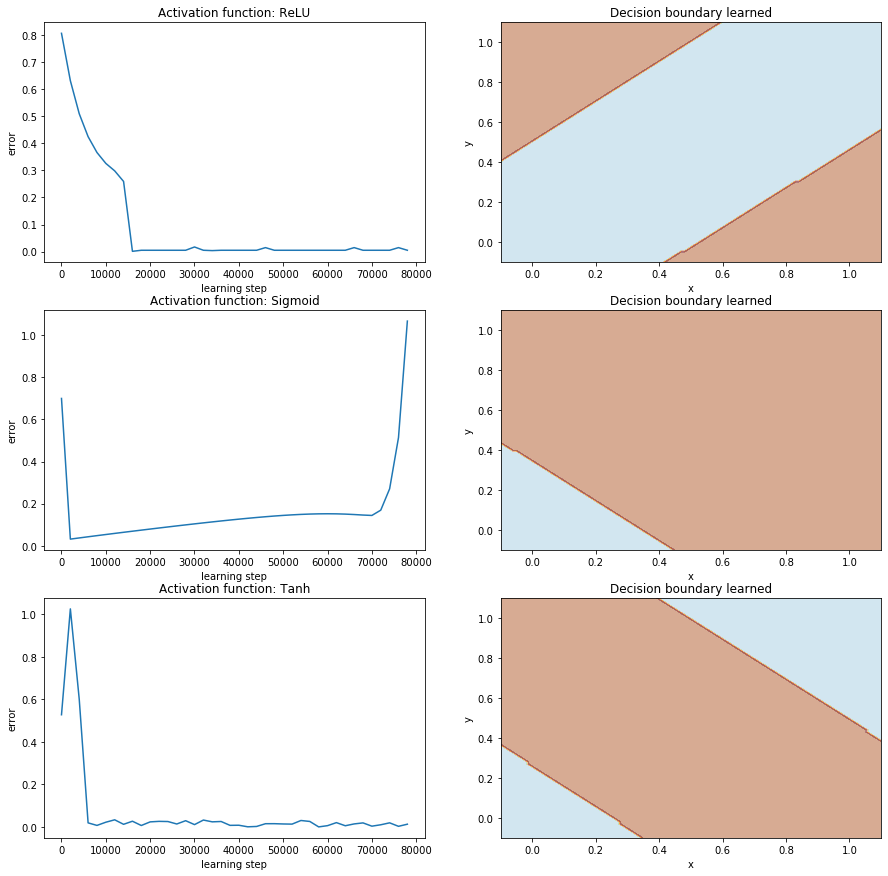

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(15,15))
for i, r in df_results.iterrows():
    axs[i][0].plot(r['steps'],r['errors'])
    axs[i][0].set_xlabel('learning step')
    axs[i][0].set_ylabel('error')
    axs[i][0].set_title('Activation function: {}'.format(r['activation']))

    model = torch.nn.DataParallel(r['model']).cuda() if use_cuda else r['model']
    plot_decision_boundarie(axs[i][1],-.1,1.1,-.1,1.1,0.01,model)
    axs[i][1].set_xlabel('x')
    axs[i][1].set_ylabel('y')
    axs[i][1].set_title('Decision boundary learned')